In [311]:
import warnings
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import MeanSquaredError

# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import math
warnings.filterwarnings('ignore')

In [312]:
tf.compat.v1.reset_default_graph() 
tf.compat.v1.disable_eager_execution()

There are 3732 observations in the training data
There are 1504 observations in the test data


<AxesSubplot:xlabel='Date'>

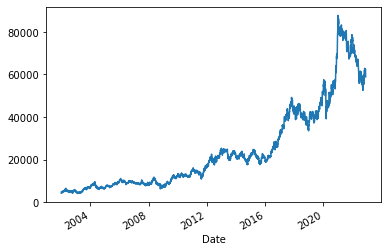

In [313]:
SAMSUNG = yf.download('005930.KS', 
                      start='2002-01-01', 
                      end='2022-12-08', 
                      progress=False)
all_data = SAMSUNG[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2016-10-21'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2016-10-22':].shape[0]) + " observations in the test data")
all_data['Adj Close'].plot()


In [314]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2016-10-21':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )

In [315]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:'2016-10-20'].iloc[:,0:1].values
    ts_test  = all_data['2016-10-21':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
 
    # scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train = np.array(X_train) 
    y_train = np.array(y_train) 

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2016-10-20'], all_data["Adj Close"]['2016-10-21':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [316]:
X_train, Y_train, X_test, sc = ts_train_test_normalize(all_data,30,3)

X_train_see= pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
Y_train_see= pd.DataFrame(Y_train)
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")
pd.concat([Y_train_see])
Y_train[3699]=np.append(Y_train[3699],0.0)



There are 3700 samples in the training data
There are 1502 samples in the test data


In [317]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
for i in range(len(X_train)):
    if len(X_train[i]) != 30:
        print(len(i))
        
for i in range(len(Y_train)):
    if len(Y_train[i]) != 3:
        print(len(i))
        
for i in range(len(X_test)):
    if len(X_test[i]) != 30:
        print(len(i))
Y_train = np.array([np.array(val) for val in Y_train])       
print(X_train.dtype)
print(Y_train.dtype)
print(X_test.dtype)
    

(3700, 30, 1)
(3700,)
(1502, 30, 1)
float64
float64
float64


In [319]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=64, activation='tanh'))
    my_LSTM_model.add(Dropout(0.1))
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dense(units=3))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=100,batch_size=10, verbose=0, validation_split=0.3)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, Y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  

In [ ]:
import numpy as np

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))

def MSE(true, pred):
    return np.mean(np.square(true-pred))

In [ ]:
RMSE_value= "{:.2f}".format(np.sqrt(MSE(X_test, LSTM_prediction[0][:])))
print("RMSE = ",RMSE_value)

MAE_value= "{:.2f}".format(MAE(X_test, LSTM_prediction[0][:]))
print("MAE = ",MAE_value)

MAPE_value= "{:.2f}".format(MAPE(X_test, LSTM_prediction[0][:]))
print("MAPE = ",MAPE_value)

SMAPE_value= "{:.2f}".format(SMAPE(X_test, LSTM_prediction[0][:]))
print("SMAPE = ",SMAPE_value)